In [148]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import linalg as alg


# UK coal usage dat
# Data Header
#   0         1                       2                           3                           4               5                   6                  7                 8  
# Year	Number of Deep Mines	Number of NCB2          	Number of Opencast Sites	Total Output3	Deepmined Output	Opencast Output4	Coal Imports	Employment
#   	Producing Coal      	Mines at End of Year    	 Mines at End of Year    	Million tonnes	Million tonnes   	Million tonnes  	Million tonnes	Thousands
# Global Temperature data -> to be converted to only UK temperature data
# Data Header
# dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude

# 'coal.xls'
# 'temp.csv'



class model:
    def __init__(self):
        pass
    
    def getData(self, xDataFile, yDataFile):
        self.X = pd.read_excel(xDataFile).values
        self.X_years_label = self.X[25:-13,0]
        self.Y = pd.read_csv(yDataFile)
        self.X = self.X[25:-13,1:]     # The rest is description strings
        self.Y = self.Y.values[30000:60000, :]
    
    def fixX(self):  # Changing NaN's with the column avgs
        avgs = np.ones(self.X.shape[1])
        for i in range(0,self.X.shape[1]):
            for j in range(0,self.X.shape[0]):
                if self.X[j,i] == '..':
                    self.X[j,i] = -1
        self.X = self.X.astype('float64')
        nans = np.argwhere(self.X!=self.X)
        for i in nans:
            self.X[i] = -1
        avg = 0
        count = 0
        avgs = np.ones(self.X.shape[1])
        for i in range(0,self.X.shape[1]):
            avg = 0
            count = 0
            for j in range(0,self.X.shape[0]):
                if self.X[j,i] != -1:
                    avg = avg + self.X[j,i]
                    count = count + 1
            avgs[i] = avg / count
            avg = 0
            count = 0
        for i in range(0,self.X.shape[1]):
            for j in range(0,self.X.shape[0]):
                if(self.X[j,i] == -1):
                    self.X[j,i] = avgs[i]
        self.X = self.X[:-6,:].T
        self.X_train = self.X[:,:80]
        self.X_test = self.X[:,20:]
                    
    def fixY(self): # Getting the avgd temp data of UK between 1913-2013
        count = 0
        for i in range(self.Y.shape[1]):
            for j in range(self.Y.shape[0]):
                if self.Y[j,4] == 'United Kingdom':
                    count = count + 1

        y = np.empty([count, 2])
        c = 0
        for i in range(0, self.Y.shape[1]):
            for j in range(0, self.Y.shape[0]):
                if self.Y[j,4] == 'United Kingdom':
                    y[c,0] = int(self.Y[j,0].split('-')[0])
                    y[c,1] = self.Y[j,1]
                    c = c + 1

        y_avgD = np.zeros([2013-1743+1,2])
        start_year = 1743
        index = 0
        for i in range(y.shape[0]):
            index = int(y[i,0]-1743)
            y_avgD[index,1] = y_avgD[index,1] + y[i, 1]
            y_avgD[index,0] = y[i,0]
        y_avgD[:,1] = y_avgD[:,1]/(2013-1743)
        self.Y = y_avgD[170:-1,1]
        self.Y_train = self.Y[:80]
        self.Y_test = self.Y[20:]

    
    def fit(self):
        self.coefficients = alg.inv(self.X_train @ self.X_train.T) @ self.X_train @ self.Y_train.T
        return self.coefficients
        
    def predict(self):
        self.y_pred = self.coefficients @ self.X_test
        return self.y_pred
    
    def plot(self):
        plt.plot(np.linspace(1,self.Y_test.shape[0],self.Y_test.shape[0]), self.Y_test, label='Test')
        plt.plot(np.linspace(1,self.y_pred.shape[0],self.y_pred.shape[0]), self.y_pred, label='Prediction')
        plt.legend()
        plt.show()                                                        # Plotting the results
    
    def error(self):
        self.error = np.abs(self.y_pred - self.Y_test).mean()/self.Y_test.mean()*100
        return self.error
        






In [149]:
m = model()

m.getData('coal.xls', 'temp.csv')
m.fixX()
m.fixY()


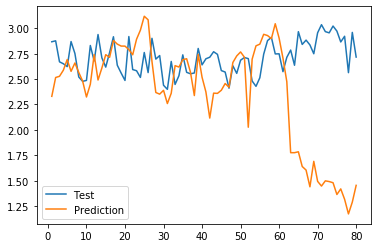

Error:  17.319004967928038
I had 100 years, used the first 80 to create coefficients, the rest to test


In [150]:
m.fit()
m.predict()
m.plot()
print('Error: ', m.error())

print('I had 100 years, used the first 80 to create coefficients, the rest to test')
